In [1]:
import glob
import os
import sys
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from multiprocessing import Process
import gc

import tensorflow as tf
import sklearn
import time

import numpy as np
import pandas as pd
from pandas import DataFrame

#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2024-02-19 16:50:10.670624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 16:50:11.308050: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 16:50:12.381671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-19 16:50:12.381810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# argumentos
n = len(sys.argv)
print("Total arguments passed:", n)
iteracoes = 0
cycle_index = 1
finalIterations = 0
if(n > 0):
    for value in sys.argv:
        print("arg:", value)
        if("iterations=" in value):
            try:
                iteracoes = int(value.replace("iterations=",""))
            except:
                print("no")
        
        if("cycle=" in value):
            try:
                cycle_index = int(value.replace("cycle=",""))
            except:
                print("no")
print("iteracoes:",iteracoes)      
print("cycle:",cycle_index)

Total arguments passed: 3
arg: /home/guilherme/cpu-tensorflow-marcelo/nvidia-smi/envs/flower/lib/python3.9/site-packages/ipykernel_launcher.py
arg: -f
arg: /home/guilherme/.local/share/jupyter/runtime/kernel-1d6c1112-b61f-47c2-8cf9-dbfe996672f7.json
iteracoes: 0
cycle: 1


In [3]:

cycles = [0,1,2]
iteracoes = 200
print("iteracoes:",iteracoes)
print("cycles:",cycles)

iteracoes: 200
cycles: [0, 1, 2]


In [4]:
# input folder
#inputFolders = "../02-transformed-data-new-testes/dados2019/"
inputFolderPath = "../data_2019_processed/"

# General configuration
NUMBER_OF_ITERATIONS_FINAL = 200
    
NUM_EPOCHS = 1
BATCH_SIZE = 32
VERBOSE = 0


# usado para checkpoints
if(iteracoes > 0):
    NUMBER_OF_ITERATIONS_FINAL = iteracoes
    
NUMBER_OF_ITERATIONS = NUMBER_OF_ITERATIONS_FINAL

# train file name modifier
fileSufixTrain = "" # _smote for smote

#fl.common.logger.configure(identifier="myFlowerExperiment", filename="log_"+outputFolder+".txt")

In [5]:
# selected features
inputFeatures = ["activity","location","day_of_week","light","phone_lock","proximity","sound","time_to_next_alarm", "minutes_day"]
outputClasses = ["awake","asleep"]
#outputClasses = ["class"]

In [6]:
# client datasets used on the training process (75% of data)
trainFolders =  ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                #'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                #'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4']
                #'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                #'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                #'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                #'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                #'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                #'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']
            
# client datasets used on the training process (25% of data)
testFolders =  [#'0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                #'0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                #'2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                #'2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                #'7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                #'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                #'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                #'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                #'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                #'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                #'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                #'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                #'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                #'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                #'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                #'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                #'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                #'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                #'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4'] 
                'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']

In [7]:
def generateMetrics(y_test,yhat_probs):
    # predict crisp classes for test set deprecated
    #yhat_classes = model.predict_classes(X_test, verbose=0)
    #yhat_classes = np.argmax(yhat_probs,axis=1)
    yhat_classes = yhat_probs.round()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    #print(matrix)
    
    array = []
    results = dict()
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    results['cohen_kappa_score'] = kappa
    results['roc_auc_score'] = auc
    results['matrix'] = ("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    results['TP'] = matrix[0][0]
    results['FP'] = matrix[0][1]
    results['FN'] = matrix[1][0]
    results['TN'] = matrix[1][1]
    
    array.append(accuracy)
    array.append(precision)
    array.append(recall)
    array.append(f1)
    array.append(kappa)
    array.append(auc)
    array.append("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    array.append(matrix[0][0]) # TP
    array.append(matrix[0][1]) # FP
    array.append(matrix[1][0]) # FN
    array.append(matrix[1][1]) # TN
    
    return results, array

# y_test     = Array with real values
# yhat_probs = Array with predicted values
def printMetrics(y_test,yhat_probs):
    # generate metrics
    results, array= generateMetrics(y_test,yhat_probs)

    # accuracy: (tp + tn) / (p + n)
    accuracy = results['accuracy']
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = results['precision']
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = results['recall'] 
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = results['f1_score']
    print('F1 score: %f' % f1)
    # kappa
    kappa = results['cohen_kappa_score']
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = results['roc_auc_score']
    print('ROC AUC: %f' % auc)
    # confusion matrix
    print("\Confusion Matrix")
    matrix = results['matrix']
    print(matrix)
    
    return results, array

def generateGlobalMetrics(metrics):
    accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score = 0,0,0,0,0,0
    for metric in metrics:
        accuracy = accuracy + metric['accuracy']
        precision = precision + metric['precision']
        recall = recall + metric['recall']
        f1_score = f1_score + metric['f1_score']
        cohen_kappa_score = cohen_kappa_score + metric['cohen_kappa_score']
        roc_auc_score = roc_auc_score + metric['roc_auc_score']
        
    # mean
    size = len(metrics)
    print(size)
    accuracy = accuracy / size
    precision = precision / size
    recall = recall / size
    f1_score = f1_score / size
    cohen_kappa_score = cohen_kappa_score / size
    roc_auc_score = roc_auc_score / size
    
    return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score]

def showGlobalMetrics(metrics):
    res = generateGlobalMetrics(metrics)
    
    accuracy = res[0]
    precision = res[1]
    recall = res[2]
    f1_score = res[3]
    cohen_kappa_score = res[4]
    roc_auc_score = res[5]
    
    #show:\
    print("accuracy: ",accuracy)
    print("precision: ",precision)
    print("recall: ",recall)
    print("f1_score: ",f1_score)
    print("cohen_kappa_score: ",cohen_kappa_score)
    print("roc_auc_score: ",roc_auc_score)
    
    return res

In [8]:
# take the list of directories and concat them
def loadDataFromFolders(foldersToLoad,inputFolders,fileType = ""):
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        #print(trainingDataSet[i])
        if(i == 0):
            temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        else:
            dataset = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
            temp_data = pd.concat([temp_data, dataset])
    # return the dataset        
    return temp_data

# take the list of directories and concat them
def loadDataFromFoldersOnList(foldersToLoad,inputFolders,fileType = ""):
    clientList = []
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        #print(trainingDataSet[i])
        temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        print("Adding to the list: ", temp_data.shape)
        clientList.append(temp_data)
    # return the dataset        
    return clientList

def loadDataFromLastCycleFoldersOnList(iferredCycleDataFolder):
    clientList = []
    foldersToLoad = trainFolders
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,iferredCycleDataFolder+"/student_"+currentFolder+".csv")
        #print(trainingDataSet[i])
        temp_data = pd.read_csv(iferredCycleDataFolder+"/student_"+currentFolder+".csv")
        temp_data['class'] = temp_data['awake']
        temp_data['class'] = temp_data['class'].astype('int32')
        
        mapper = {0: 'asleep', 1: 'awake'}

        temp_data['class'] = temp_data['class'].map(mapper)
        #temp_data['class'] = temp_data['class'].apply(lambda tpl: [mapper.get(x) for x in tpl])

        #temp_data['fullcoursenames'] = [[mapper.get(x) for x in tpl] for tpl in temp_data['itemsets']]

        #del temp_data['awake']
        #del temp_data['asleep']
        
        print("Adding to the list: ", temp_data.shape)
        clientList.append(temp_data)
    # return the dataset        
    return clientList

Load datasets

In [9]:
print("Preparing test data")
 
# test data comprising 25% of the data. It must be fixed to all models being evaluated
#X_test  = pd.read_csv(inputFolders+"test/allData-classification-numeric-normalized.csv")
X_test = loadDataFromFolders(testFolders,inputFolderPath,"")

print()
# undestand the dataset by looking on their infos
print(X_test.info())

X_test

Preparing test data
8 datasets
0 - rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw ../data_2019_processed/student_rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw_transformed.csv
1 - RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI ../data_2019_processed/student_RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI_transformed.csv
2 - VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is ../data_2019_processed/student_VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is_transformed.csv
3 - Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw ../data_2019_processed/student_Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw_transformed.csv
4 - XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA ../data_2019_processed/student_XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA_transformed.csv
5 - YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw ../data_2019_processed/student_YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw_transformed.csv
6 - ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM ../data_2019_processed/student_ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM_transformed.csv


activity  location     timestamp  time_to_next_alarm     sound  \
0          0.75       1.0  0.000000e+00            0.000000  0.515992   
1          0.25       1.0  3.211282e-07            0.000000  0.542171   
2          0.25       1.0  6.422564e-07            0.000000  0.515992   
3          0.00       1.0  6.422564e-07            0.000000  0.515992   
4          0.25       1.0  6.422564e-07            0.000000  0.531341   
...         ...       ...           ...                 ...       ...   
23747      0.25       1.0  5.819100e-03            0.000099  0.000000   
23748      0.25       1.0  5.819743e-03            0.000694  0.000000   
23749      0.25       1.0  5.819743e-03            0.000595  0.000000   
23750      0.25       1.0  5.820064e-03            0.000595  0.000000   
23751      0.50       1.0  5.820064e-03            0.000496  0.000000   

       proximity  phone_lock     light  day_of_week  minutes_day  \
0            1.0         0.0  0.000000     1.000000     0.678249   
1            0.0         1.0  0.000007     1.000000     0.678944   
2            0.0         1.0  0.000000     1.000000     0.679639   
3            0.0         1.0  0.000000     1.000000     0.680334   
4            0.0         1.0  0.000000     1.000000     0.681028   
...          ...         ...       ...          ...          ...   
23747        1.0         1.0  0.000236     0.166667     0.510076   
23748        1.0         1.0  0.000325     0.166667     0.512856   
23749        1.0         1.0  0.000325     0.166667     0.513551   
23750        1.0         1.0  0.000354     0.166667     0.513551   
23751        0.0         1.0  0.000000     0.166667     0.514246   

                  timestamp_text   class  
0      2018-05-14 16:16:08+00:00  asleep  
1      2018-05-14 16:17:39+00:00  asleep  
2      2018-05-14 16:18:39+00:00  asleep  
3      2018-05-14 16:19:09+00:00  asleep  
4      2018-05-14 16:20:09+00:00  asleep  
...                          ...     ...  
23747  2018-06-13 12:14:37+00:00   awake  
23748  2018-06-13 12:18:08+00:00   awake  
23749  2018-06-13 12:19:08+00:00   awake  
23750  2018-06-13 12:19:38+00:00   awake  
23751  2018-06-13 12:20:08+00:00   awake  

[134888 rows x 12 columns]

In [10]:
# one-hot encoding function
def transform_output_nominal_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data['awake']
    dataset['asleep'] = one_hot_encoded_data['asleep']
    
    return dataset

# one-hot encoding function
def transform_output_numerical_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data[0]
    dataset['asleep'] = one_hot_encoded_data[1]
    
    return dataset

# transform output to one_hot_encoding for the testing dataset
X_test = transform_output_nominal_class_into_one_hot_encoding(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134888 entries, 0 to 23751
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            134888 non-null  float64
 1   location            134888 non-null  float64
 2   timestamp           134888 non-null  float64
 3   time_to_next_alarm  134888 non-null  float64
 4   sound               134888 non-null  float64
 5   proximity           134888 non-null  float64
 6   phone_lock          134888 non-null  float64
 7   light               134888 non-null  float64
 8   day_of_week         134888 non-null  float64
 9   minutes_day         134888 non-null  float64
 10  timestamp_text      134888 non-null  object 
 11  class               134888 non-null  object 
 12  awake               134888 non-null  bool   
 13  asleep              134888 non-null  bool   
dtypes: bool(2), float64(10), object(2)
memory usage: 13.6+ MB


In [11]:
def transform_data_type(dataframe):
    
    # transform inputs
    for column in inputFeatures:
        dataframe[column] = dataframe[column].astype('float32')
    
    # transform outputs
    for column in outputClasses:
        dataframe[column] = dataframe[column].astype('float32')
    
    return dataframe

# transforms the data
X_test = transform_data_type(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134888 entries, 0 to 23751
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            134888 non-null  float32
 1   location            134888 non-null  float32
 2   timestamp           134888 non-null  float64
 3   time_to_next_alarm  134888 non-null  float32
 4   sound               134888 non-null  float32
 5   proximity           134888 non-null  float32
 6   phone_lock          134888 non-null  float32
 7   light               134888 non-null  float32
 8   day_of_week         134888 non-null  float32
 9   minutes_day         134888 non-null  float32
 10  timestamp_text      134888 non-null  object 
 11  class               134888 non-null  object 
 12  awake               134888 non-null  float32
 13  asleep              134888 non-null  float32
dtypes: float32(11), float64(1), object(2)
memory usage: 9.8+ MB


In [12]:
print("Preparing X_train data")
# cycle data list
trainDataPerCycle = []

for cycle_index in cycles:
    clientList = [] 
    print()
    print()
    print()
    print("Loading data from cycle: "+str(cycle_index))
    if(cycle_index == 0):
        print("Loading original data")
        fileSufixTrain = ""
        # load cliend data
        clientList = loadDataFromFoldersOnList(trainFolders,inputFolderPath,fileSufixTrain)
        
        # transform output to one_hot_encoding for the input dataset
        for i in range(0,len(clientList)):
            clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
            #print (clientList[i])
                
    else:
        cycle_index = cycle_index - 1
        print("Loading inferred data from previous cycle: "+str(cycle_index))
        localInputFolderPath = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
        localInputFolderPath = localInputFolderPath + "/inferred_datasets"
        # load cliend data
        clientList = loadDataFromLastCycleFoldersOnList(localInputFolderPath)

        # transform output to one_hot_encoding for the input dataset
        for i in range(0,len(clientList)):
            clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
            #print (clientList[i])

    #  add on the list
    trainDataPerCycle.append(clientList)

    NUMBER_OF_CLIENTS = len(clientList)
    print("Cycle: "+str(cycle_index)+ " found clients: "+str(len(clientList)))

print()
print("Loaded Cycles: "+str(len(trainDataPerCycle)))

Preparing X_train data



Loading data from cycle: 0
Loading original data
19 datasets
0 - 0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs ../data_2019_processed/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs_transformed.csv
Adding to the list:  (17993, 12)
1 - 0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA ../data_2019_processed/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA_transformed.csv
Adding to the list:  (11561, 12)
2 - 2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0 ../data_2019_processed/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0_transformed.csv
Adding to the list:  (3383, 12)
3 - 2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys ../data_2019_processed/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys_transformed.csv
Adding to the list:  (19389, 12)
4 - 7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA ../data_2019_processed/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA_transformed.csv
Adding to the list:  (2753, 12)
5 - a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4 ../data_2019_processe

In [13]:
print("Preparing inferred data")
# cycle data list
inferredDataPerCycle = []

for cycle_index in cycles:
    print()
    print()
    print()
    print("Loading inferred data from cycle: "+str(cycle_index))
    clientList = []
    iferredCycleDataFolder = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
    iferredCycleDataFolder = iferredCycleDataFolder+"/inferred_datasets"

    fileSufixTrain = ""
    # load cliend data
    clientList = loadDataFromLastCycleFoldersOnList(iferredCycleDataFolder)

    # transform output to one_hot_encoding for the input dataset
    for i in range(0,len(clientList)):
        clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
        #print (clientList[i])

    #  add on the list
    inferredDataPerCycle.append(clientList)

    NUMBER_OF_CLIENTS = len(clientList)
    print("Cycle: "+str(cycle_index)+ " found clients: "+str(len(clientList)))

print()
print("Cycles loaded: "+str(len(inferredDataPerCycle)))

Preparing inferred data



Loading inferred data from cycle: 0
19 datasets
0 - 0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs.csv
Adding to the list:  (17993, 12)
1 - 0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA.csv
Adding to the list:  (11561, 12)
2 - 2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0 result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0.csv
Adding to the list:  (3383, 12)
3 - 2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys.csv
Adding to the list:  (19389, 12)
4 - 7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA result_unbalanced_epoch_1_rounds_200_cycle_0/inferred_datasets/student_7EYF5I04EVqisUJCVN

Generate Graths

In [14]:
print("Prepering the test dataset")
# selects the data to train and test
X_test_data = X_test[inputFeatures]
y_test_label = X_test[outputClasses]

# transtorm data to tensor slices
#client_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_data.values, y_test_label.values))

#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)

#print(client_test_dataset.element_spec)
#client_test_dataset

Prepering the test dataset


--
--
Evaluate data
--
--

In [15]:
#np.array(attribute1)

In [16]:
trainDataPerCycle[0][0]

activity  location     timestamp  time_to_next_alarm     sound  \
0          0.00       0.0  0.000000e+00            0.982143  0.000000   
1          0.00       0.0  0.000000e+00            0.982143  0.000000   
2          0.25       0.5  3.211923e-07            0.982044  0.604408   
3          0.25       0.5  3.211923e-07            0.982044  0.604408   
4          0.25       0.5  3.211923e-07            0.981944  0.601849   
...         ...       ...           ...                 ...       ...   
17988      0.25       1.0  6.277381e-03            0.983333  0.586128   
17989      0.00       1.0  6.277381e-03            0.983234  0.572395   
17990      0.75       1.0  6.277703e-03            0.983135  0.572395   
17991      0.00       1.0  6.277703e-03            0.983135  0.615209   
17992      0.25       1.0  6.278024e-03            0.983036  0.615209   

       proximity  phone_lock     light  day_of_week  minutes_day  \
0            1.0         0.0  0.000617     0.000000     0.597637   
1            1.0         0.0  0.000617     0.000000     0.597637   
2            1.0         0.0  0.000583     0.000000     0.598332   
3            1.0         0.0  0.005117     0.000000     0.598332   
4            1.0         0.0  0.000700     0.000000     0.599027   
...          ...         ...       ...          ...          ...   
17988        0.0         1.0  0.000000     0.166667     0.551077   
17989        0.0         1.0  0.000000     0.166667     0.551772   
17990        0.0         1.0  0.000000     0.166667     0.552467   
17991        0.0         1.0  0.000000     0.166667     0.553162   
17992        0.0         1.0  0.000000     0.166667     0.553857   

                  timestamp_text  class  awake  asleep  
0      2018-05-15 14:20:45+00:00  awake   True   False  
1      2018-05-15 14:20:45+00:00  awake   True   False  
2      2018-05-15 14:21:15+00:00  awake   True   False  
3      2018-05-15 14:21:45+00:00  awake   True   False  
4      2018-05-15 14:22:15+00:00  awake   True   False  
...                          ...    ...    ...     ...  
17988  2018-06-13 13:13:44+00:00  awake   True   False  
17989  2018-06-13 13:14:54+00:00  awake   True   False  
17990  2018-06-13 13:15:44+00:00  awake   True   False  
17991  2018-06-13 13:16:15+00:00  awake   True   False  
17992  2018-06-13 13:17:21+00:00  awake   True   False  

[17993 rows x 14 columns]

In [17]:
inferredDataPerCycle[0][0]

activity  location  day_of_week     light  phone_lock  proximity  \
0          0.00       0.0     0.000000  0.000617         0.0        1.0   
1          0.00       0.0     0.000000  0.000617         0.0        1.0   
2          0.25       0.5     0.000000  0.000583         0.0        1.0   
3          0.25       0.5     0.000000  0.005117         0.0        1.0   
4          0.25       0.5     0.000000  0.000700         0.0        1.0   
...         ...       ...          ...       ...         ...        ...   
17988      0.25       1.0     0.166667  0.000000         1.0        0.0   
17989      0.00       1.0     0.166667  0.000000         1.0        0.0   
17990      0.75       1.0     0.166667  0.000000         1.0        0.0   
17991      0.00       1.0     0.166667  0.000000         1.0        0.0   
17992      0.25       1.0     0.166667  0.000000         1.0        0.0   

          sound  time_to_next_alarm  minutes_day  awake  asleep  class  
0      0.000000            0.982143     0.597637   True   False  awake  
1      0.000000            0.982143     0.597637   True   False  awake  
2      0.604408            0.982044     0.598332   True   False  awake  
3      0.604408            0.982044     0.598332   True   False  awake  
4      0.601849            0.981944     0.599027   True   False  awake  
...         ...                 ...          ...    ...     ...    ...  
17988  0.586128            0.983333     0.551077   True   False  awake  
17989  0.572395            0.983234     0.551772   True   False  awake  
17990  0.572395            0.983135     0.552467   True   False  awake  
17991  0.615209            0.983135     0.553162   True   False  awake  
17992  0.615209            0.983036     0.553857   True   False  awake  

[17993 rows x 12 columns]

In [18]:
from collections import Counter
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

datasetsMixed = []

for cycle in cycles:
    trainData = trainDataPerCycle[cycle]
    inferredData = inferredDataPerCycle[cycle]

    dsClient = []
    for ds in range(0,len(trainData)):
        client = DataFrame(data=trainData[ds]["awake"], columns=["awake"])

        client["awake_pred"] = inferredData[ds]["awake"]
        dsClient.append(client)
    print("Mixed datasets: "+str(len(dsClient)))

    datasetsMixed.append(dsClient)

print("Mixed cycles: "+str(len(datasetsMixed)))



Mixed datasets: 19
Mixed datasets: 19
Mixed datasets: 19
Mixed cycles: 3


In [19]:
datasetsMixed[0][0]

awake  awake_pred
0       True        True
1       True        True
2       True        True
3       True        True
4       True        True
...      ...         ...
17988   True        True
17989   True        True
17990   True        True
17991   True        True
17992   True        True

[17993 rows x 2 columns]

In [20]:
metrics = None
metricsa = None
metricsAll = []

for i in range(0,len(datasetsMixed)): 
    cycleList = datasetsMixed[i]
    print("Clients found: "+str(len(cycleList)))
    metricsCycle = []

    for j in range(0,len(cycleList)): 
        print("Selected client: "+str(j))
        client = (cycleList[j])        
        
        metrics,metricsa = generateMetrics(client["awake"],client["awake_pred"])
        metricsCycle.append(metrics)
        print()
        print()
        printMetrics(client["awake"],client["awake_pred"])    
        #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
        print()
        print()

        
    print()
    print("Clients processed: "+str(len(metricsCycle)))
    print()
    metricsAll.append(metricsCycle)

Clients found: 19
Selected client: 0


Accuracy: 0.893292
Precision: 0.932621
Recall: 0.951227
F1 score: 0.941832
Cohens kappa: 0.297863
ROC AUC: 0.635722
\Confusion Matrix
[[ 529 1123][ 797 15544]]


Selected client: 1


Accuracy: 0.706946
Precision: 0.751476
Recall: 0.873621
F1 score: 0.807958
Cohens kappa: 0.204184
ROC AUC: 0.590498
\Confusion Matrix
[[ 1046 2357][ 1031 7127]]


Selected client: 2


Accuracy: 0.803429
Precision: 0.833254
Recall: 0.847384
F1 score: 0.840259
Cohens kappa: 0.584832
ROC AUC: 0.791016
\Confusion Matrix
[[ 969 350][ 315 1749]]


Selected client: 3


Accuracy: 0.774614
Precision: 0.760216
Recall: 0.948302
F1 score: 0.843906
Cohens kappa: 0.455728
ROC AUC: 0.705397
\Confusion Matrix
[[ 3206 3726][ 644 11813]]


Selected client: 4


Accuracy: 0.815837
Precision: 0.943187
Recall: 0.841715
F1 score: 0.889567
Cohens kappa: 0.346072
ROC AUC: 0.732784
\Confusion Matrix
[[ 204 123][ 384 2042]]


Selected client: 5


Accuracy: 0.632138
Precision: 0.645124
Recall: 0

In [25]:
from statistics import mean
print("Print average accuracy among - pred with train")
listAccuracies = []
for i in range(0,len(metricsAll)): 
    cycleList = metricsAll[i]


    print("Clients found: "+str(len(cycleList)))
    metricsCycle = []
    for j in range(0,len(cycleList)): 
        #print("Selected client: "+str(j))
        clientMetrics = (cycleList[j]) 

        accuracy = clientMetrics['accuracy']

        metricsCycle.append(accuracy)
    
    print(metricsCycle)
    print(mean(metricsCycle))

    listAccuracies.append(mean(metricsCycle))

Print average accuracy among - pred with train
Clients found: 19
[0.8932918357138887, 0.7069457659372027, 0.803428909252143, 0.7746144721233689, 0.8158372684344352, 0.6321376143335717, 0.8649629086166136, 0.740937380172846, 0.7287443267776097, 0.8907449763110603, 0.5831283627978479, 0.7703223816134506, 0.8012738054152417, 0.8991567716399931, 0.8371013013523858, 0.3471318473395173, 0.8457293666026872, 0.7866177070583436, 0.8770949720670391]
0.7683790512399603
Clients found: 19
[0.9889401433890957, 0.9827869561456621, 0.9411764705882353, 0.9649285677445975, 0.9625862695241555, 0.9730116309707532, 0.9771337735387625, 0.970504085184202, 0.9769667170953101, 0.9729210913249469, 0.9633358954650268, 0.9769782508098103, 0.9746493897656323, 0.9773274823610394, 0.9605001275835673, 0.9682034242466196, 0.9694997600767754, 0.9519923840609276, 0.9664804469273743]
0.9694696245685523
Clients found: 19
[0.9939420885900072, 0.9820949744831762, 0.9207803724504877, 0.9801433802671617, 0.9295314202687976, 0

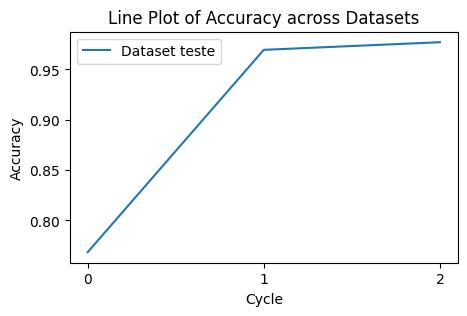

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns

# Create subplots
fig, ax = plt.subplots(figsize=(5, 3))

# Plot accuracy for each dataset
cycle = np.arange(len(listAccuracies))  # Generate cycle values
accuracy = listAccuracies
ax.plot(cycle,accuracy, label=f'Dataset teste')

# cycles
cycles = range(0, len(listAccuracies))

# Set labels and title
ax.set_xlabel('Cycle')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy across Datasets')
ax.set_xticks(cycles)

# Add legend
ax.legend()

# Show plot
plt.show()


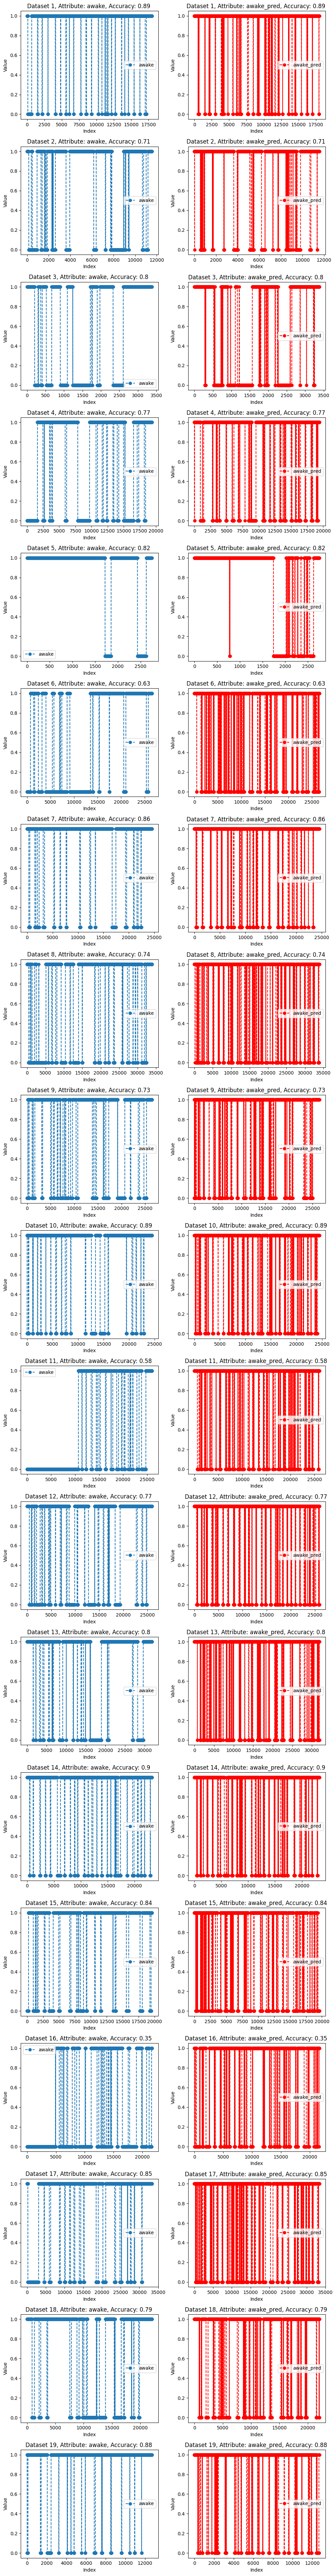

In [22]:
import matplotlib.pyplot as plt
import numpy as np

cycle_s = 0
# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns
data = datasetsMixed[cycle_s] # Your array with 18 datasets
selectedAttributes = ['awake','awake_pred']

# Determine the number of datasets and attributes
num_datasets = len(data)
num_attributes = len(selectedAttributes)  # Assuming all datasets have the same number of attributes

# Calculate the number of rows and columns for subplots
num_rows = num_datasets
num_cols = num_attributes  # Two subplots per attribute

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# Plot each dataset in its own subplot
for i, dataset in enumerate(data):
    for j, attribute in enumerate(selectedAttributes):
        ax = axs[i, j]
        if(j % 2 == 1):
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o', color='red')
        else:
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o')
        ax.set_title(f'Dataset {i+1}, Attribute: {attribute}, Accuracy: {round(metricsAll[cycle_s][i]["accuracy"], 2)} ')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

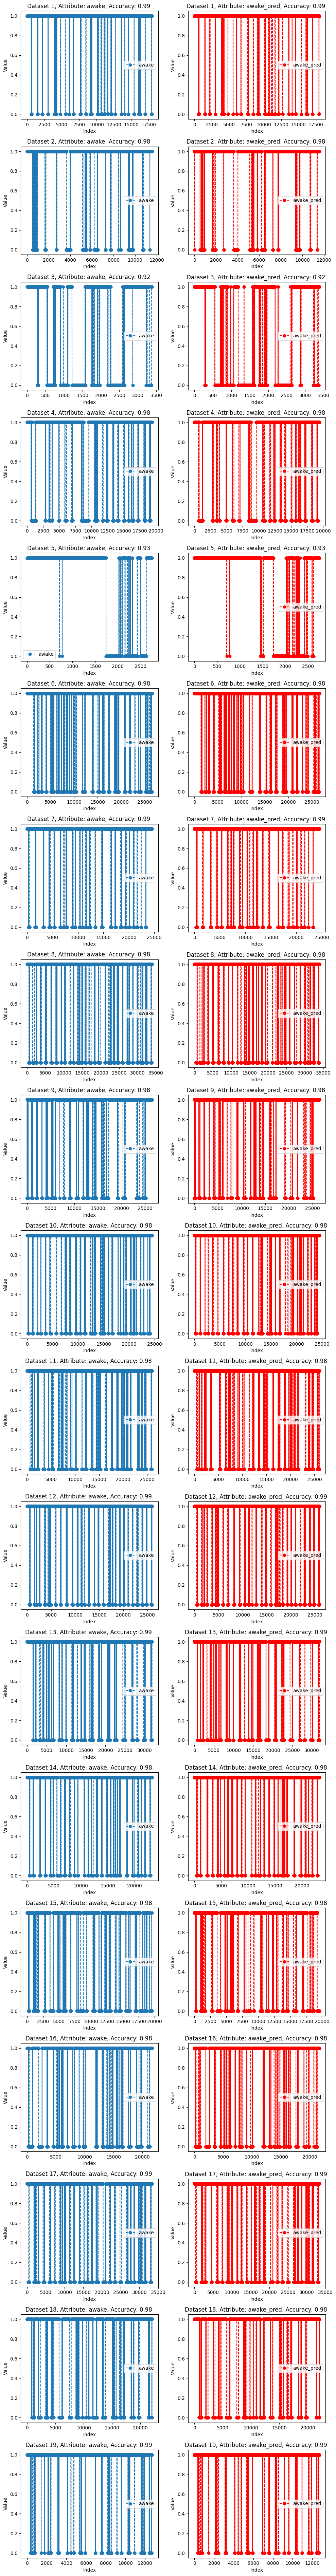

In [23]:
import matplotlib.pyplot as plt
import numpy as np

cycle_s = 2
# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns
data = datasetsMixed[cycle_s] # Your array with 18 datasets
selectedAttributes = ['awake','awake_pred']

# Determine the number of datasets and attributes
num_datasets = len(data)
num_attributes = len(selectedAttributes)  # Assuming all datasets have the same number of attributes

# Calculate the number of rows and columns for subplots
num_rows = num_datasets
num_cols = num_attributes  # Two subplots per attribute

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# Plot each dataset in its own subplot
for i, dataset in enumerate(data):
    for j, attribute in enumerate(selectedAttributes):
        ax = axs[i, j]
        if(j % 2 == 1):
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o', color='red')
        else:
            ax.plot(dataset[attribute], label=attribute, linestyle='--', marker='o')
        ax.set_title(f'Dataset {i+1}, Attribute: {attribute}, Accuracy: {round(metricsAll[cycle_s][i]["accuracy"], 2)} ')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Evaluate models

In [41]:
print("creating model")

def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(9,)),
      #tf.keras.layers.Dense(9, activation=tf.keras.activations.relu), 
      tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(8, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
      #tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
    ])

keras_model = create_keras_model()
#keras_model.summary()
keras_model.summary()

creating model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 314
Trainable params: 314
Non-trainable params: 0
_________________________________________________________________


2024-02-19 17:32:13.817433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 17:32:13.959453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-02-19 17:32:13.959728: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-02-19 17:32:13.967698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [55]:
checkpointModels_h5 = []

selected_round_checkpoint = NUMBER_OF_ITERATIONS_FINAL

for cycle_index in cycles:
    checkPointFolder = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
    checkPointFolder = checkPointFolder + "/checkpoints"

    filename_h5 = checkPointFolder+"/round-"+str(selected_round_checkpoint)+"-weights.h5"

    checkpointModels_h5.append(filename_h5)

In [56]:
checkpointModels_h5

['result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5',
 'result_unbalanced_epoch_1_rounds_200_cycle_1/checkpoints/round-200-weights.h5',
 'result_unbalanced_epoch_1_rounds_200_cycle_2/checkpoints/round-200-weights.h5']

In [70]:
def getMetricUsingCheckpoint(checkpointFileName,inputTestData,inputTestLabels,model = None):
    print("Loading checkpoint: "+checkpointFileName)

    if(model is None):
        keras_model = create_keras_model()
        keras_model.load_weights(checkpointFileName)
    else:
        keras_model = model

    print()
    print("Starting to test")
    # cycle data list
    #trainDataPerCycle = []

    yhat_probs = keras_model.predict(inputTestData,verbose=VERBOSE)

    # as we deal with a classification problem with one hot encoding, we must round the values to 0 and 1.
    yhat_probs_rounded = yhat_probs.round()

    # create a dataframe with the predicted data
    y_predicted_df = pd.DataFrame(data=yhat_probs_rounded,columns=['awake_pred','asleep_pred']) 

    metrics,metricsa = generateMetrics(y_predicted_df["awake_pred"],inputTestLabels["awake"])
    
    return metrics, y_predicted_df
      

In [65]:
# checkpoint test metrics
metricsTestsPerCycle = []
for checkpoint in checkpointModels_h5:

    metricsTCycle, y_predicted_df = getMetricUsingCheckpoint(checkpoint,X_test_data,y_test_label)

    #trainDataPerCycle.append(metrics)
    print()
    printMetrics(y_predicted_df["awake_pred"],y_test_label["awake"])    
    #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
    print()
    print()

    metricsTestsPerCycle.append(metricsTCycle)

Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.746597
Precision: 0.862651
Recall: 0.796061
F1 score: 0.828019
Cohens kappa: 0.349712
ROC AUC: 0.690236
\Confusion Matrix
[[ 18423 13101][ 21080 82284]]


Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_1/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.749681
Precision: 0.865409
Recall: 0.797756
F1 score: 0.830206
Cohens kappa: 0.357069
ROC AUC: 0.694542
\Confusion Matrix
[[ 18576 12838][ 20927 82547]]


Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_2/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.748325
Precision: 0.864685
Recall: 0.796743
F1 score: 0.829325
Cohens kappa: 0.353355
ROC AUC: 0.692643
\Confusion Matrix
[[ 18462 12907][ 21041 82478]]




In [ ]:
#    trainData = trainDataPerCycle[cycle]
#    inferredData = inferredDataPerCycle[cycle]

#    dsClient = []
#    for ds in range(0,len(trainData)):
#        client = DataFrame(data=trainData[ds]["awake"], columns=["awake"])
#
#        client["awake_pred"] = inferredData[ds]["awake"]
#        dsClient.append(client)
#    print("Mixed datasets: "+str(len(dsClient)))

In [74]:
metrics = None
metricsa = None
metricsAllLocal = []

for i in range(0,len(datasetsMixed)):
    if(i ==0):
        cycleList = trainDataPerCycle[i]
    else:
        cycleList = inferredDataPerCycle[i-1]
    selectedCheckpoint = checkpointModels_h5[i]
    # load model
    keras_model = create_keras_model()
    keras_model.load_weights(selectedCheckpoint)
    
    print("Clients found: "+str(len(cycleList)))
    
    metricsCycle = []

    for j in range(0,len(cycleList)): 
        print("Selected client: "+str(j))
        client = (cycleList[j])

        local_client_data  = client[inputFeatures]
        local_client_label = client[outputClasses]
    
        metrics, y_predicted_df = getMetricUsingCheckpoint(selectedCheckpoint,local_client_data,local_client_label,keras_model)
        
        metricsCycle.append(metrics)
        print()
        printMetrics(local_client_label["awake"],y_predicted_df["awake_pred"])    
        #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
        print()
        print()

        
    print()
    print("Clients processed: "+str(len(metricsCycle)))
    print()
    metricsAllLocal.append(metricsCycle)

Clients found: 19
Selected client: 0
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.893292
Precision: 0.932621
Recall: 0.951227
F1 score: 0.941832
Cohens kappa: 0.297863
ROC AUC: 0.635722
\Confusion Matrix
[[ 529 1123][ 797 15544]]


Selected client: 1
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.706946
Precision: 0.751476
Recall: 0.873621
F1 score: 0.807958
Cohens kappa: 0.204184
ROC AUC: 0.590498
\Confusion Matrix
[[ 1046 2357][ 1031 7127]]


Selected client: 2
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.803429
Precision: 0.833254
Recall: 0.847384
F1 score: 0.840259
Cohens kappa: 0.584832
ROC AUC: 0.791016
\Confusion Matrix
[[ 969 350][ 315 1749]]


Selected client: 3
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/check

In [77]:
len(metricsAllLocal[0])

19

In [78]:
len(metricsAllLocal)

3

In [79]:
metrics = None
metricsa = None
metricsAllLocalOriginal = []

for i in range(0,len(datasetsMixed)):
    trainDataPerCycle[0]

    selectedCheckpoint = checkpointModels_h5[i]
    # load model
    keras_model = create_keras_model()
    keras_model.load_weights(selectedCheckpoint)
    
    print("Clients found: "+str(len(cycleList)))
    
    metricsCycle = []

    for j in range(0,len(cycleList)): 
        print("Selected client: "+str(j))
        client = (cycleList[j])

        local_client_data  = client[inputFeatures]
        local_client_label = client[outputClasses]
    
        metrics, y_predicted_df = getMetricUsingCheckpoint(selectedCheckpoint,local_client_data,local_client_label,keras_model)
        
        metricsCycle.append(metrics)
        print()
        printMetrics(local_client_label["awake"],y_predicted_df["awake_pred"])    
        #printMetrics(realLabel["asleep"],predLabel["asleep_pred"])
        print()
        print()

        
    print()
    print("Clients processed: "+str(len(metricsCycle)))
    print()
    metricsAllLocalOriginal.append(metricsCycle)

Clients found: 19
Selected client: 0
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.988940
Precision: 0.997420
Recall: 0.990703
F1 score: 0.994050
Cohens kappa: 0.915686
ROC AUC: 0.977627
\Confusion Matrix
[[ 1170 43][ 156 16624]]


Selected client: 1
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.982787
Precision: 0.990194
Recall: 0.988839
F1 score: 0.989516
Cohens kappa: 0.941460
ROC AUC: 0.971890
\Confusion Matrix
[[ 1971 93][ 106 9391]]


Selected client: 2
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoints/round-200-weights.h5

Starting to test

Accuracy: 0.941176
Precision: 0.954740
Recall: 0.950664
F1 score: 0.952698
Cohens kappa: 0.874934
ROC AUC: 0.938077
\Confusion Matrix
[[ 1180 95][ 104 2004]]


Selected client: 3
Loading checkpoint: result_unbalanced_epoch_1_rounds_200_cycle_0/checkpoin

In [82]:
from statistics import mean
print("Print average accuracy among - pred with train")
listAccuracies = []
for i in range(0,len(metricsAllLocalOriginal)): 
    cycleList = metricsAllLocalOriginal[i]


    print("Clients found: "+str(len(cycleList)))
    metricsCycle = []
    for j in range(0,len(cycleList)): 
        #print("Selected client: "+str(j))
        clientMetrics = (cycleList[j]) 

        accuracy = clientMetrics['accuracy']

        metricsCycle.append(accuracy)
    
    print(metricsCycle)
    print(mean(metricsCycle))

    listAccuracies.append(mean(metricsCycle))

Print average accuracy among - pred with train
Clients found: 19
[0.9889401433890957, 0.9827869561456621, 0.9411764705882353, 0.9649285677445975, 0.9625862695241555, 0.9730116309707532, 0.9771337735387625, 0.970504085184202, 0.9769667170953101, 0.9729210913249469, 0.9633358954650268, 0.9769782508098103, 0.9746493897656323, 0.9773274823610394, 0.9605001275835673, 0.9682034242466196, 0.9694997600767754, 0.9519923840609276, 0.9664804469273743]
0.9694696245685523
Clients found: 19
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999213156031159]
0.9999958587159534
Clients found: 19
[0.9939420885900072, 0.9820949744831762, 0.9207803724504877, 0.9801433802671617, 0.9295314202687976, 0.979109421462717, 0.9881796690307328, 0.982036987877179, 0.9818078668683813, 0.9793334422479987, 0.9782090699461953, 0.9869273484497918, 0.9862579612838452, 0.981672689726381, 0.977545292166369, 0.9777562416355162, 0.9875539827255279, 0.9838614624416337, 0.98678102132

In [83]:
from statistics import mean
print("Print average accuracy among - pred with train")
listAccuracies = []
for i in range(0,len(metricsAll)): 
    cycleList = metricsAll[i]


    print("Clients found: "+str(len(cycleList)))
    metricsCycle = []
    for j in range(0,len(cycleList)): 
        #print("Selected client: "+str(j))
        clientMetrics = (cycleList[j]) 

        accuracy = clientMetrics['accuracy']

        metricsCycle.append(accuracy)
    
    print(metricsCycle)
    print(mean(metricsCycle))

    listAccuracies.append(mean(metricsCycle))

Print average accuracy among - pred with train


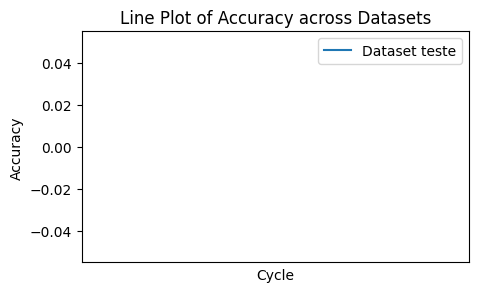

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Your array containing the datasets
# Let's assume it's named 'data'
# Each element of 'data' represents a row and the attributes are the columns

# Create subplots
fig, ax = plt.subplots(figsize=(5, 3))

# Plot accuracy for each dataset
cycle = np.arange(len(listAccuracies))  # Generate cycle values
accuracy = listAccuracies
ax.plot(cycle,accuracy, label=f'Dataset teste')

# cycles
cycles = range(0, len(listAccuracies))

# Set labels and title
ax.set_xlabel('Cycle')
ax.set_ylabel('Accuracy')
ax.set_title('Line Plot of Accuracy across Datasets')
ax.set_xticks(cycles)

# Add legend
ax.legend()

# Show plot
plt.show()

In [39]:
y_test_label

awake  asleep
0        0.0     1.0
1        0.0     1.0
2        0.0     1.0
3        0.0     1.0
4        0.0     1.0
...      ...     ...
23747    1.0     0.0
23748    1.0     0.0
23749    1.0     0.0
23750    1.0     0.0
23751    1.0     0.0

[134888 rows x 2 columns]